In [1]:
%matplotlib inline

In [ ]:
"Hello world :)"


# Example: Bayesian Neural Network with SteinVI
We demonstrate how to use SteinVI to predict housing prices using a BNN for the Boston Housing prices dataset
from the UCI regression benchmarks.


In [1]:
import argparse
from collections import namedtuple
import datetime
from functools import partial
from time import time

from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from jax import random
import jax.numpy as jnp

import numpyro
from numpyro import deterministic
from numpyro.contrib.einstein import IMQKernel, SteinVI
from numpyro.contrib.einstein.mixture_guide_predictive import MixtureGuidePredictive
from numpyro.distributions import Gamma, Normal
from numpyro.examples.datasets import BOSTON_HOUSING, load_dataset
from numpyro.infer import init_to_uniform
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adagrad

DataState = namedtuple("data", ["xtr", "xte", "ytr", "yte"])


c:\Users\12lui\anaconda3\envs\NewTrading\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:


def load_data() -> DataState:
    _, fetch = load_dataset(BOSTON_HOUSING, shuffle=False)
    x, y = fetch()
    xtr, xte, ytr, yte = train_test_split(x, y, train_size=0.90, random_state=1)

    return DataState(*map(partial(jnp.array, dtype=float), (xtr, xte, ytr, yte)))


def normalize(val, mean=None, std=None):
    """Normalize data to zero mean, unit variance"""
    if mean is None and std is None:
        # Only use training data to estimate mean and std.
        std = jnp.std(val, 0, keepdims=True)
        std = jnp.where(std == 0, 1.0, std)
        mean = jnp.mean(val, 0, keepdims=True)
    return (val - mean) / std, mean, std


def model(x, y=None, hidden_dim=50, subsample_size=100):
    """BNN described in section 5 of [1].

    **References:**
        1. *Stein variational gradient descent: A general purpose bayesian inference algorithm*
        Qiang Liu and Dilin Wang (2016).
    """

    prec_nn = numpyro.sample(
        "prec_nn", Gamma(1.0, 0.1)
    )  # hyper prior for precision of nn weights and biases

    n, m = x.shape

    with numpyro.plate("l1_hidden", hidden_dim, dim=-1):
        # prior l1 bias term
        b1 = numpyro.sample(
            "nn_b1",
            Normal(
                0.0,
                1.0 / jnp.sqrt(prec_nn),
            ),
        )
        assert b1.shape == (hidden_dim,)

        with numpyro.plate("l1_feat", m, dim=-2):
            w1 = numpyro.sample(
                "nn_w1", Normal(0.0, 1.0 / jnp.sqrt(prec_nn))
            )  # prior on l1 weights
            assert w1.shape == (m, hidden_dim)

    with numpyro.plate("l2_hidden", hidden_dim, dim=-1):
        w2 = numpyro.sample(
            "nn_w2", Normal(0.0, 1.0 / jnp.sqrt(prec_nn))
        )  # prior on output weights

    b2 = numpyro.sample(
        "nn_b2", Normal(0.0, 1.0 / jnp.sqrt(prec_nn))
    )  # prior on output bias term

    # precision prior on observations
    prec_obs = numpyro.sample("prec_obs", Gamma(1.0, 0.1))
    with numpyro.plate(
        "data",
        x.shape[0],
        subsample_size=subsample_size,
        dim=-1,
    ):
        batch_x = numpyro.subsample(x, event_dim=1)
        if y is not None:
            batch_y = numpyro.subsample(y, event_dim=0)
        else:
            batch_y = y

        loc_y = deterministic("y_pred", jnp.maximum(batch_x @ w1 + b1, 0) @ w2 + b2)

        numpyro.sample(
            "y",
            Normal(
                loc_y, 1.0 / jnp.sqrt(prec_obs)
            ),  # 1 hidden layer with ReLU activation
            obs=batch_y,
        )

100%|██████████| 1000/1000 [00:40<00:00, 24.94it/s, norm Stein force: 261.549]


[[31.182419 25.802711 20.77026  ... 21.165453 20.42289  18.392101]
 [32.05836  25.240383 20.916258 ... 22.988853 20.58666  20.906088]
 [30.04574  25.525715 19.151455 ... 21.374767 22.16175  20.955492]
 ...
 [33.792538 28.369705 18.126387 ... 20.666626 19.966022 22.514824]
 [32.05114  25.60406  19.808043 ... 19.763813 18.071526 20.371937]
 [33.175415 25.28183  19.571926 ... 19.37989  18.173382 23.406166]]
Time taken: 0:00:46
RMSE: 2.84


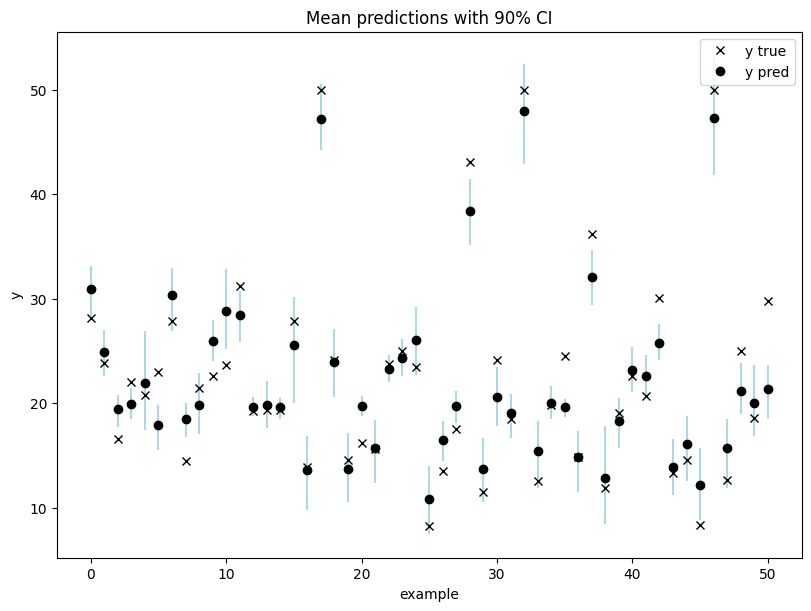

In [31]:
def main(args):
    data = load_data()

    inf_key, pred_key, data_key = random.split(random.PRNGKey(args.rng_key), 3)
    # normalize data and labels to zero mean unit variance!
    x, xtr_mean, xtr_std = normalize(data.xtr)
    y, ytr_mean, ytr_std = normalize(data.ytr)

    rng_key, inf_key = random.split(inf_key)

    guide = AutoNormal(model, init_loc_fn=partial(init_to_uniform, radius=0.1))

    stein = SteinVI(
        model,
        guide,
        Adagrad(0.05),
        IMQKernel(),
        # ProbabilityProductKernel(guide=guide, scale=1.),
        repulsion_temperature=args.repulsion,
        num_stein_particles=args.num_stein_particles,
        num_elbo_particles=args.num_elbo_particles,
    )

    start = time()

    # use keyword params for static (shape etc.)!
    result = stein.run(
        rng_key,
        args.max_iter,
        x,
        y,
        hidden_dim=args.hidden_dim,
        subsample_size=args.subsample_size,
        progress_bar=args.progress_bar,
    )
    time_taken = time() - start

    pred = MixtureGuidePredictive(
        model,
        guide=stein.guide,
        params=stein.get_params(result.state),
        num_samples=100,
        guide_sites=stein.guide_sites,
    )
    xte, _, _ = normalize(
        data.xte, xtr_mean, xtr_std
    )  # use train data statistics when accessing generalization
    preds = pred(
        pred_key, xte, subsample_size=xte.shape[0], hidden_dim=args.hidden_dim
    )["y_pred"]

    y_pred = preds * ytr_std + ytr_mean
    print(y_pred)
    rmse = jnp.sqrt(jnp.mean((y_pred.mean(0) - data.yte) ** 2))

    print(rf"Time taken: {datetime.timedelta(seconds=int(time_taken))}")
    print(rf"RMSE: {rmse:.2f}")

    # compute mean prediction and confidence interval around median
    mean_prediction = y_pred.mean(0)

    ran = np.arange(mean_prediction.shape[0])
    percentiles = np.percentile(preds * ytr_std + ytr_mean, [5.0, 95.0], axis=0)

    # make plots
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    ax.add_collection(
        LineCollection(
            zip(zip(ran, percentiles[0]), zip(ran, percentiles[1])), colors="lightblue"
        )
    )
    ax.plot(data.yte, "kx", label="y true")
    ax.plot(mean_prediction, "ko", label="y pred")
    ax.set(xlabel="example", ylabel="y", title="Mean predictions with 90% CI")
    ax.legend()
    fig.savefig("stein_bnn.pdf")


if __name__ == "__main__":
    from jax import config

    config.update("jax_debug_nans", True)

    parser = argparse.ArgumentParser()
    parser.add_argument("--subsample-size", type=int, default=100)
    parser.add_argument("--max-iter", type=int, default=1000)
    parser.add_argument("--repulsion", type=float, default=1.0)
    parser.add_argument("--verbose", type=bool, default=True)
    parser.add_argument("--num-elbo-particles", type=int, default=50)
    parser.add_argument("--num-stein-particles", type=int, default=5)
    parser.add_argument("--progress-bar", type=bool, default=True)
    parser.add_argument("--rng-key", type=int, default=142)
    parser.add_argument("--device", default="cpu", choices=["cpu"])
    parser.add_argument("--hidden-dim", default=50, type=int)

    args, unknown = parser.parse_known_args()

    numpyro.set_platform(args.device)

    main(args)

In [29]:
args.device

'cpu'